In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
#%matplotlib inline doesn't seem to play nice with jupyter lab on local machine
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage import io


%matplotlib inline
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings**.

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
data_sample = pd.read_csv('sample_labels.csv')

print("all_xray_df: ", all_xray_df.shape)
print("data_sample: ", data_sample.shape)

all_xray_df:  (112120, 12)
data_sample:  (5606, 11)


In [5]:
# Stat with some code to make our target a little more accessible
unique_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_labels

for x in unique_labels:
    all_xray_df[x] = [x in label for label in all_xray_df['Finding Labels']]

In [6]:
# Review files
all_xray_df.sample(6)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81854,00020138_001.png,No Finding,1,20138,47,F,PA,2786,2449,0.143000,...,False,False,False,False,False,True,False,False,False,False
10751,00002790_000.png,No Finding,0,2790,55,F,PA,2500,2048,0.171000,...,False,False,False,False,False,True,False,False,False,False
4895,00001304_004.png,No Finding,4,1304,44,M,AP,2500,2048,0.168000,...,False,False,False,False,False,True,False,False,False,False
26607,00006972_004.png,No Finding,4,6972,17,M,AP,2500,2048,0.168000,...,False,False,False,False,False,True,False,False,False,False
711,00000181_014.png,No Finding,14,181,50,F,AP,2500,2048,0.168000,...,False,False,False,False,False,True,False,False,False,False
4479,00001210_002.png,Infiltration,2,1210,67,M,PA,2021,2021,0.194311,...,False,False,False,True,False,False,False,False,False,False


In [7]:
data_sample.sample(6)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2458,00012324_000.png,No Finding,0,12324,056Y,M,PA,2838,2991,0.143000,0.143000
184,00001047_003.png,No Finding,3,1047,078Y,F,PA,2598,2991,0.143000,0.143000
2200,00011379_029.png,Pleural_Thickening|Pneumothorax,29,11379,009Y,M,PA,1998,2067,0.143000,0.143000
3944,00019464_004.png,Effusion|Pleural_Thickening,4,19464,040Y,F,PA,1775,2022,0.194311,0.194311
2346,00011925_008.png,Consolidation|Effusion,8,11925,054Y,M,AP,2500,2048,0.168000,0.168000
3711,00018226_000.png,Infiltration,0,18226,054Y,F,PA,2048,2500,0.168000,0.168000


## View Position

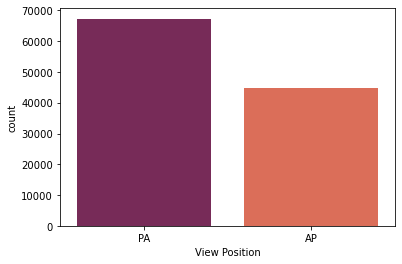

In [8]:
sns.countplot('View Position', data=all_xray_df, palette="rocket")

X-ray images were acquired in postero-anterior (PA) or antero-posterior (AP) orientations, with the majority being collected in the former.

Let's take a closer look at what these view positions consists of.

115.58639621734619
69.69817930158288


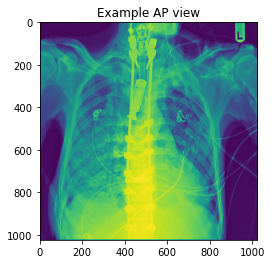

In [9]:
# What's the difference between these positions
ap_view = io.imread('/data/images_008/images/00016778_026.png')

plt.title("Example AP view")
plt.imshow(ap_view)

print(ap_view.mean())
print(ap_view.std())

115.58639621734619
69.69817930158288


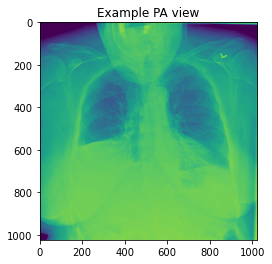

In [10]:
pa_view = io.imread('/data/images_010/images/00022961_005.png')

plt.title("Example PA view")
plt.imshow(pa_view)

print(ap_view.mean())
print(ap_view.std())

In summary, it would appear that AP and PA view positions provide a reasonable perspective on the anatomical region of interest. It seems reasonalbe to state that views that deviate from this view may either (1) not capture the region of interest, or (2) devidate subsantial from the context of tranining such that the algorithm is not able to generalize.  

Early notes on indication and limitations would be to restrict inference on novel files to AP or PA images.

## Age 
According to documentation, we should expect (in some cases) multiple series per patient. Let's review that.

In [11]:
all_xray_df['Patient ID'].value_counts()

# Confirmed. Some patients have many (many) series assicated with their id of record.

10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
3301       1
5350       1
7399       1
19693      1
22485      1
Name: Patient ID, Length: 30805, dtype: int64

The fact that there are multiple images per subject means that the number of rows with a particular age does not reflect the total number of _subjects_ with a particular age. In addition to this, partients of certain ages may be over-or-under represented within the data (and subsequently, through training, within the algorithm) by the proportion of images that their demographic represents as a proportion of total images. Account for this through analysis.

count    30802.000000
mean        46.087559
std         16.692500
min          1.000000
25%         34.000000
50%         48.000000
75%         58.000000
max         95.000000
Name: Patient Age, dtype: float64


Text(0, 0.5, 'Frequency')

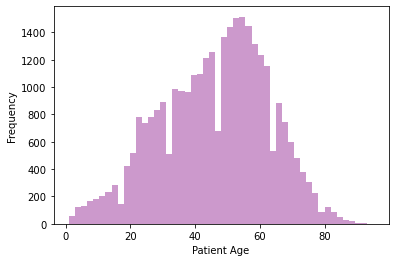

In [14]:
# Aggregate correctly
agg_age = all_xray_df[all_xray_df['Patient Age'] < 110].groupby('Patient ID').first()['Patient Age']

print(agg_age.describe()) 
# Note that this doesn't totally line up with the subject total referenced in the README... 

sns.distplot(agg_age, kde=False, color='purple')
plt.ylabel("Frequency")

It's clear that there are some fairly old (and young) individuals in this dataset. Patient age within the dataset ranges from 1 to 95 years old, with an average of 46.

It could be the case that, owing to age-related immunedeficiency, our target could be over represented in this older population. The same could be said of the younger population. Review.

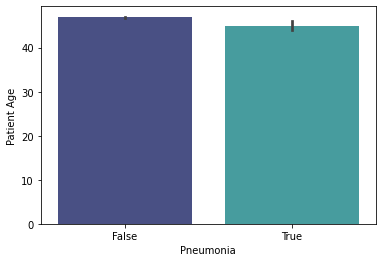

In [26]:
sns.barplot(x="Pneumonia", y="Patient Age", data=all_xray_df, estimator=np.mean, palette = "mako")

On average, the age of patients with pneumonia appears to be comparable to those without.

There is not substantial "observed" biological rational for excluding older or younger patients; however, procedurally, these cases are infrequent enough to state that our algorithm is unlikely to get sufficient training to cover these scenarios comprehensivly. 

Prelininarly suggestion is to exclude high-and-low age cases on the basis of low availablity for training.

# Gender

Proportion of pneumonia label, male
False    0.98677
True     0.01323
Name: Pneumonia, dtype: float64
-------------------
Proportion of pneumonia label, female
False    0.987843
True     0.012157
Name: Pneumonia, dtype: float64


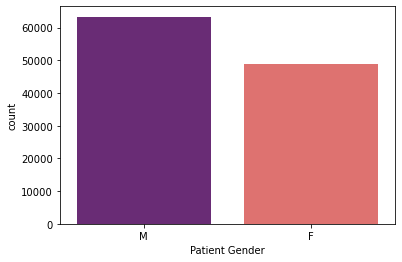

In [15]:
sns.countplot('Patient Gender', data=all_xray_df, palette="magma")

print("Proportion of pneumonia label, male")
print(all_xray_df[all_xray_df['Patient Gender'] == 'M']['Pneumonia'].value_counts(normalize=True))
print("-------------------")
print("Proportion of pneumonia label, female")
print(all_xray_df[all_xray_df['Patient Gender'] == 'F']['Pneumonia'].value_counts(normalize=True))

The gender of the population is predominantly male, however, the proportion of pneumonia labels appears to be fairly balanced across males and females.

## Distribution of labels

False    0.987237
True     0.012763
Name: Pneumonia, dtype: float64

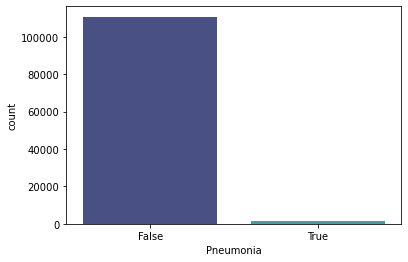

In [12]:
sns.countplot(x='Pneumonia', data=all_xray_df, palette='mako')
all_xray_df['Pneumonia'].value_counts(normalize=True)

Lastly, out of all total labels, pneumonia (and pneumonia comorbidities) account for only a small fraction of the total dataset.

This will need to be accounted for through stratification (to distribute the label across training and validation sets) as well as adjustments to the non-taget classes (to even out the prevalence of target to non-target examples). 

## Comorbidity

This is an aside: what is the age of patients with ONLY pneumonia compared to a pneumonia with comorbidities?
Are older or younger patients more prone to comorbidities.

Text(0, 0.5, 'Frequency')

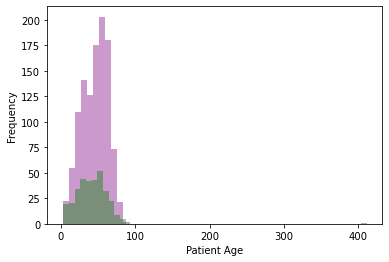

In [14]:
# Rows where pneumonia is present
pneumonia_data=all_xray_df[all_xray_df['Pneumonia'] == 1]

# Kinda hacky -- subset based on cases where the label is longer than 'pneumonia', written alone
sns.distplot(pneumonia_data[(pneumonia_data['Pneumonia'] == 1) &\
                            (pneumonia_data['Finding Labels'].str.len() > len('pneumonia')) ]['Patient Age'], 
                             kde=False, color='purple')

# Subset based on pneumonia that includes comorbidities
sns.distplot(pneumonia_data[pneumonia_data['Finding Labels'] == 'Pneumonia']['Patient Age'], kde=False, color='green')

plt.ylabel('Frequency')

Overlapping. I think our apporach to age and prevalence of the target is sound.

Moving on: a review of comorbidities

Text(0, 0.5, 'Frequency observed')

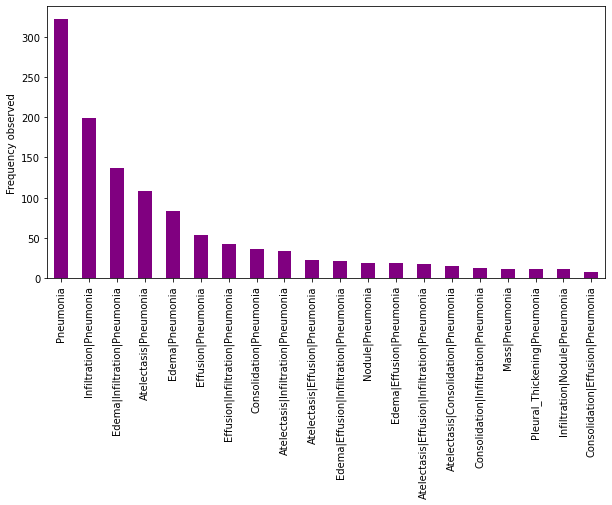

In [15]:
plt.figure(figsize=(10,5))
all_xray_df[all_xray_df['Pneumonia'] == 1]['Finding Labels'].value_counts()[0:20].plot(kind='bar', color='purple')
plt.ylabel('Frequency observed')

Comorbidities with the pneumonia label are quite common, the most prevalent appears to be infiltration. The combination of infiltration with pneumonia in ~75% as many cases as pneumonia alone. 

In terms of practical implications, it becomes necessary to account for the prevalence of labels when considering the importance of this finding. 

The conservative apporach might be to discard examples of pneumonia with comorbidities, as this could serve to bias the algorithm. Unfortunatly however, this seems impossible: first, as above, the number of labeled examples of pneumonia relative to non-target labels is already. Second, based on this analysis it seems reasonable to conclude that pneumonia "in the wild" tends to coexpress with other conditions. Being that this is the cases, an algorithm tranined on more restricted conditions might be more _theoretically_ performant (as measured through the validation set), however, in terms of real world untility, it will need to account for the common presence of other disorders. 





# Pixel level assessment 
Let's take a random sample of pnuemonia cases and compare them to non-pneumonia cases. What can be reasonably expected from a rudimentary comparison of something like pixel intensity?

In [17]:
# Add file paths for review. 
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [48]:
# Take a random sample of images with pneumonia only (cleanest possible signal)
pneumonia_paths = all_xray_df[all_xray_df["Finding Labels"] == 'Pneumonia']['path'].sample(5)

# Random sample of non-target images
non_target_paths = all_xray_df[all_xray_df["Pneumonia"] == 0]['path'].sample(5)

In [49]:
# Function to standardize pixels

def standardize_pixels(pixels):
    
    flatten_array = pixels.ravel()
    
    return (flatten_array - np.mean(flatten_array)) / np.std(flatten_array)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


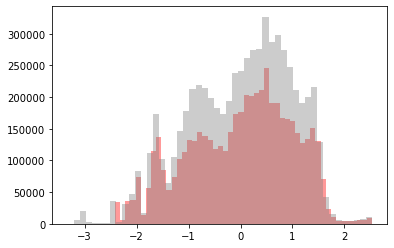

In [50]:
pneumonia_array = pd.Series()
non_target_array = pd.Series()

for i, x in enumerate(pneumonia_paths):
    
    # This should be a function
    temp_pneumonia = io.imread(x)
    temp_penumonia = standardize_pixels(temp_pneumonia)
    pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
    
    temp_non_target = io.imread(non_target_paths.iloc[i])
    temp_non_target = standardize_pixels(temp_non_target)
    non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
    

sns.distplot(pneumonia_array, kde=False, color='red')
sns.distplot(non_target_array, kde=False, color='grey')    

Well, these distributions look very similar. This does not bode well for methods based on pixel intensity alone. But, this is why CNNs are so helpful. 